In [13]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import sklearn
import warnings
np.random.seed(17)

In [6]:
train = pd.read_csv('input/train.csv', dtype={'MSSubClass': str})  
test = pd.read_csv('input/test.csv', dtype={'MSSubClass': str})

all_data = pd.concat([train,
                      test])


## Prepare the data.

Guided by the [description of data][1], we'll fill missing data with one of three values: 0, the most common value of the feature, or 'None'.

Then, with the exception of SalePrice, Id and YrSold, we'll log transform skewed numeric features and standardize all numeric features.
 
Finally, we log transform SalePrice.

Log transform ideas borrowed from this [kernel.][2] 



[2]: https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models


[1]: https://storage.googleapis.com/kaggle-competitions-data/kaggle/5407/data_description.txt?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1523572243&Signature=OZ5ssnLZ1t27FS3gQlpMpqa8vQlosxvBN9%2BULQSKxdPPeoQ1ajN9zqAbJWVCsJ5qrGDFR%2BMnKmri5oH8kSgTTqtgK4LfKk%2BSbV%2FoQxe37QtVsNrNQOrj5%2BX6KN%2FopA2R51FhlhN9SiNOrc%2B94kyX7IB2vnb1%2FpIkhsoQHMkeftwEeEuC5T49Oz%2FU9DJkmObAObMxryYR%2BWtjGP6PaNJ8EaDRwM5zGHoVt3DlmI8Epq%2BIltEe8AFtFO0zvpjmKbef10BCo75ceNZaYYH4Fy2FZ94tGbNf9BeskTtRtchC5NmlL1XfMJ57IkgVUQLJKWyISx9kGlnLneb6IIbwQwZGsA%3D%3D

In [7]:
fill_with_zero = [ 
    'LotFrontage',
    'MasVnrArea',
    'GarageCars',
    'TotalBsmtSF',
    'BsmtFullBath',
    'BsmtHalfBath',
    'BsmtFinSF1', 
    'BsmtFinSF2',
    'BsmtUnfSF',
    'GarageArea'
  ]

fill_with_most_common = [
    'Electrical'
]

fill_with_none = [
    'FireplaceQu',      
    'GarageType',   
    'GarageYrBlt',      
    'GarageFinish',     
    'GarageQual',       
    'GarageCond',       
    'PoolQC',          
    'Fence',
    'MiscFeature', 
    'BsmtQual',   
    'BsmtCond',          
    'BsmtExposure',      
    'BsmtFinType1',      
    'BsmtFinType2',
    'MasVnrType',
    'Alley'
]

sc = StandardScaler()

def prepData(df, unskew=False):
    dfForModel = df.copy()
    
    for col in fill_with_zero:
        dfForModel[col] = dfForModel[col].fillna(0)
    
    for col in fill_with_none:
        dfForModel[col] = dfForModel[col].fillna('None')
    
    for col in fill_with_most_common:
        dfForModel[col] = dfForModel[col].fillna(train[col].value_counts().index[0])
        
    
    
    numeric_feats = dfForModel.dtypes[dfForModel.dtypes != 'object'].index
    numeric_feats = [feat for feat in numeric_feats if feat != 'SalePrice' and feat !='Id' and feat !='YrSold']
    if unskew:
        skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))
        skewed_feats = skewed_feats[skewed_feats > 0.75]
        skewed_feats = skewed_feats.index
        dfForModel[skewed_feats] = np.log1p(dfForModel[skewed_feats])
    
    sc = StandardScaler()
    #only fit scaler on train set
    sc.fit(dfForModel[numeric_feats].iloc[:train.shape[0],:])
    dfForModel[numeric_feats] = sc.transform(dfForModel[numeric_feats])
    
    
    dfForModel["SalePrice"] = np.log1p(dfForModel["SalePrice"])
    return pd.get_dummies(dfForModel)

In [8]:
all_data_prepped = prepData(all_data, unskew=True)

X_train = all_data_prepped[:train.shape[0]].drop('SalePrice', axis=1)
X_test = all_data_prepped[train.shape[0]:].drop('SalePrice', axis=1)
y = all_data_prepped[:train.shape[0]].SalePrice
X_train.shape

(1460, 421)

In [9]:
all_data_prepped.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,Street_Grvl,Street_Pave,Utilities_AllPub,Utilities_NoSeWa
0,-0.803645,1.180528,-0.128521,0.163779,0.779431,-0.355342,1.107810,-0.242923,-0.340511,-0.404244,...,0,0,0,0,0,1,0,1,1,0
1,0.418479,-0.870117,-0.128521,0.163779,0.888257,-0.355342,-0.819964,4.021453,0.002218,-0.404244,...,0,0,0,0,0,1,0,1,1,0
2,-0.576677,1.184762,-0.128521,0.163779,0.654803,-0.355342,1.107810,-0.242923,0.230372,-0.404244,...,0,0,0,0,0,1,0,1,1,0
3,-0.439421,1.143550,-0.128521,0.163779,0.384539,-0.355342,1.107810,-0.242923,0.348034,2.844374,...,0,0,0,0,0,1,0,1,1,0
4,0.112127,1.244087,-0.128521,1.390023,0.754400,-0.355342,1.107810,-0.242923,0.295711,-0.404244,...,0,0,0,0,0,1,0,1,1,0


Save the cleaned data so we don't have to do that again. 

In [10]:
train_clean = all_data_prepped[:train.shape[0]]
X_test.to_csv('test_clean.csv', index=False)
train_clean.to_csv('train_clean.csv', index=False)

## Fit some models.

We'll try three different linear models: ridge regression, elastic net and lasso. Below is a function to help fit the models and tune their regularization hyperparameters.

In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

def runGSAndGetRMSE(est, params):
    gs = GridSearchCV(est, param_grid= params, verbose=5, scoring='neg_mean_squared_error')
    gs.fit(X_train, y)
    print(np.sqrt(gs.best_score_*-1))
    print(gs.best_params_)
    return gs.best_estimator_

### Ridge Regression

In [22]:
from sklearn.linear_model import Ridge
ridgeParams = {'alpha':[0.0001, 0.001, .01, 0.1, 1, 10, 100, 1000]}
bestRidgeEst = runGSAndGetRMSE(Ridge(), ridgeParams)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.0001 ....................................................
[CV] ........ alpha=0.0001, score=-0.024312903352602146, total=   0.1s
[CV] alpha=0.0001 ....................................................
[CV] ......... alpha=0.0001, score=-0.03242092592510118, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ......... alpha=0.0001, score=-0.02333124287351338, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] .......... alpha=0.001, score=-0.02426378262918538, total=   0.0s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.026710901258341215, total=   0.0s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s


[CV] .......... alpha=0.001, score=-0.02331475531757934, total=   0.1s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.023123493874415972, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.025042926176493417, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.023163386688494044, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........... alpha=0.1, score=-0.018465990191087953, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........... alpha=0.1, score=-0.023059080002232377, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.02221677805690469, total=   0.0s
[CV] alpha=1 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    0.9s finished


### Elastic Net

In [26]:
from sklearn.linear_model import ElasticNet
elasticParams = {'alpha':[0.0001, .01, 0.1, 1], 'l1_ratio': [0.30, 0.6, 0.9]}
bestElEst = runGSAndGetRMSE(ElasticNet(), elasticParams)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] alpha=0.0001, l1_ratio=0.3 ......................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0.3, score=-0.015524652045152975, total=   0.4s
[CV] alpha=0.0001, l1_ratio=0.3 ......................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0.3, score=-0.02060676403790059, total=   0.4s
[CV] alpha=0.0001, l1_ratio=0.3 ......................................
[CV]  alpha=0.0001, l1_ratio=0.3, score=-0.02083514075053352, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.6 ......................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s


[CV]  alpha=0.0001, l1_ratio=0.6, score=-0.013826677539056849, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.6 ......................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.4s remaining:    0.0s
/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.0001, l1_ratio=0.6, score=-0.019218507723995564, total=   0.3s
[CV] alpha=0.0001, l1_ratio=0.6 ......................................
[CV]  alpha=0.0001, l1_ratio=0.6, score=-0.01987585777009655, total=   0.6s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV]  alpha=0.0001, l1_ratio=0.9, score=-0.013000146796132579, total=   0.2s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................


/home/ryanryanadmin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


[CV]  alpha=0.0001, l1_ratio=0.9, score=-0.018518519047062736, total=   0.4s
[CV] alpha=0.0001, l1_ratio=0.9 ......................................
[CV]  alpha=0.0001, l1_ratio=0.9, score=-0.019170457808326706, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.3 ........................................
[CV]  alpha=0.01, l1_ratio=0.3, score=-0.014247800681347544, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.3 ........................................
[CV]  alpha=0.01, l1_ratio=0.3, score=-0.020691992348080536, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.3 ........................................
[CV]  alpha=0.01, l1_ratio=0.3, score=-0.019447854521269552, total=   0.0s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV]  alpha=0.01, l1_ratio=0.6, score=-0.01599340203907997, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.6 ........................................
[CV]  alpha=0.01, l1_ratio=0.6, score=-0.021774399265407605, total=   0.1s
[CV] alpha=0.01, l1_ratio=0.6 ................

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    4.0s finished


0.129980063699
{'alpha': 0.0001, 'l1_ratio': 0.9}


### Lasso

In [27]:
from sklearn.linear_model import Lasso
lassoParams = {'alpha':[0.0001, 0.001, .01, 0.1, 1, 10, 100, 1000]}
bestLassoEst = runGSAndGetRMSE(Lasso(), lassoParams)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] alpha=0.0001 ....................................................
[CV] ........ alpha=0.0001, score=-0.012845331490504071, total=   0.2s
[CV] alpha=0.0001 ....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV] ........ alpha=0.0001, score=-0.018343014430508914, total=   0.3s
[CV] alpha=0.0001 ....................................................
[CV] ........ alpha=0.0001, score=-0.018999838988523837, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.012371603225422568, total=   0.0s
[CV] alpha=0.001 .....................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.7s remaining:    0.0s


[CV] ......... alpha=0.001, score=-0.018313060633256637, total=   0.1s
[CV] alpha=0.001 .....................................................
[CV] ......... alpha=0.001, score=-0.016986357386776767, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.017132789267280155, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] ........... alpha=0.01, score=-0.02255534500871121, total=   0.0s
[CV] alpha=0.01 ......................................................
[CV] .......... alpha=0.01, score=-0.021712175967367152, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ........... alpha=0.1, score=-0.050230764066581675, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] ............ alpha=0.1, score=-0.04951635469697085, total=   0.0s
[CV] alpha=0.1 .......................................................
[CV] .

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:    1.1s finished


It looks like the lasso was the winner. Let's take look at its coefficients.

In [39]:
lasso_coef = bestLassoEst.coef_
coef_df = pd.DataFrame({'feature': X_train.columns, 'weight': lasso_coef, 'absol': abs(lasso_coef)})
coef_df = coef_df.sort_values(by='absol', ascending=False)
coef_df.head()

,absol,feature,weight
342,0.203238,MSZoning_C (all),-0.203238
14,0.127080,GrLivArea,0.127080
362,0.082824,Neighborhood_Crawfor,0.082824
26,0.076849,OverallQual,0.076849
378,0.068951,Neighborhood_StoneBr,0.068951


The lasso has shrunk 80% of our features to zero.

In [40]:
1 - (coef_df.absol > 0).sum() / coef_df.shape[0]

0.80522565320665085

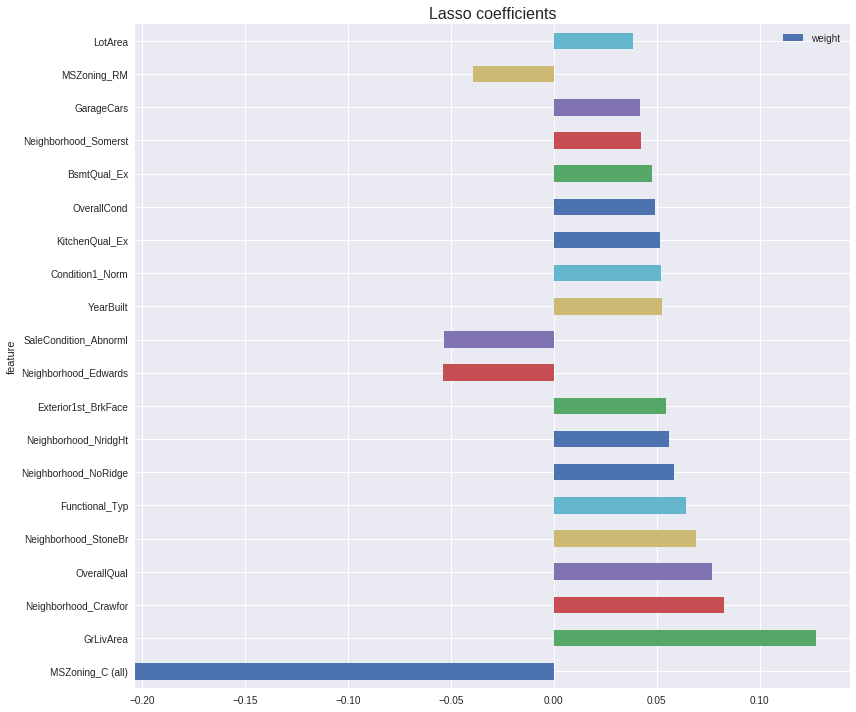

In [42]:
fig, ax = plt.subplots(1,1, figsize=(12, 10))
coef_df.iloc[:20, :].plot(kind='barh', x='feature', y='weight', ax=ax)
_= ax.set_title("Lasso coefficients", fontsize=16)
plt.tight_layout()
plt.savefig('imgs/lasso_coef.png')

Fit our tuned model on all the data prior to submission.

In [36]:
bestLassoEst.fit(X_train, y)

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

Make predictions on the test set and undo our log transform so that the values will be on their original scale.

In [37]:
preds = np.expm1(bestLassoEst.predict(X_test))
solution = pd.DataFrame({"id":X_test.Id, "SalePrice":preds}, columns=['id', 'SalePrice'])

solution.to_csv("lasso_sol_2.csv", index = False)

Let's save the model so we can use it later

In [38]:
from sklearn.externals import joblib
joblib.dump(bestLassoEst, 'lasso_alpha_.001.pkl')

['lasso_alpha_.001.pkl']